# Data preprocessing and generating embeddings


This exploartion follows this [tutorial](https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee) by Huber

In [1]:
%matplotlib inline

import os
import pickle
import json
import pandas as pd
import seaborn as sn
import numpy as np
import matchms
from matplotlib import pyplot as plt
from collections import OrderedDict
from tqdm.notebook import tqdm 
from datetime import datetime
#import numba
import spec2vec
from spec2vec import SpectrumDocument
from spec2vec.vector_operations import calc_vector
import mol2vec


os.chdir('../raw_data')
#path = '/lustre/BIF/nobackup/lmeli001/raw_data'


In [2]:
os.listdir()

['.lr_find_17300ae8-1491-4bfb-9d21-3e55fbf35c84.ckpt',
 '.lr_find_19a4454c-1c39-4397-a263-e987db4681d7.ckpt',
 '.lr_find_30a4e462-02be-41dd-be7d-1af911a661eb.ckpt',
 '.lr_find_4de30680-dbc1-4896-b0dc-08cb1a4dd704.ckpt',
 '.lr_find_5bade18e-9267-4771-b35d-92e4a90a66dc.ckpt',
 '.lr_find_621dcaa2-3333-40d8-8d27-d567944bf2aa.ckpt',
 '.lr_find_a691ac49-7783-4992-b10b-d413b83aa3be.ckpt',
 '.lr_find_b98fd81b-7e40-4cbf-bee1-b05939a11819.ckpt',
 'ALL_3_hidden_max3_50_vs_cca_MS2DeepScore.png',
 'ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'common_class_tanis.png',
 'data.json',
 'dcca',
 'dcca_train_z_df_stratified_max3',
 'dcca_val_z_df_stratified_max3',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_uni

#### Functions to load and or write to pickle files

A general class of function used across this project to write to pickle/json files as well as read in csv/pickle files. 

In [3]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    def write_json(self, data):
        with open('data.json', 'wb') as f:
            json.dump(data, f)
            return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

# Part 1: Data preprocessing


<b>Load raw spectra data</b>


The spectra data can be downloaded from [GNPS](https://gnps-external.ucsd.edu/gnpslibrary/ALL_GNPS.json)

For this project, the data was downloaded on 15th December, 2021

In [4]:
# Load spec data
spec_path = './ALL_GNPS_15_12_2021_positive_annotated.pickle'
spec_data = Files(spec_path).load_pickle()

len(spec_data)

314318

<b>load chemical class information</b>

Chemical class information is needed to annotate the raw spectra data

To minimise memory usage, we only load the columns required in downstream steps i.e 'inchi_key', 'cf_class'

In [11]:
# load class info
class_info = './ALL_GNPS_15_12_2021_positive_annotated_classifications.txt'

class_info_df = Files(class_info).load_csv(sep = '\t',\
                                           usecols= ['inchi_key', 'cf_class'])
                           
class_info_df.head()

,inchi_key,cf_class
0,IYDKWWDUBYWQGF-NNAZGLEUSA-N,Peptidomimetics
1,KNGPFNUOXXLKCN-ZNCJFREWSA-N,Peptidomimetics
2,WXDBUBIFYCCNLE-NSCMQRKRSA-N,Oxepanes
3,CGZKSPLDUIRCIO-RPCRKUJJSA-N,Indoles and derivatives
4,USXIYWCPCGVOKF-LERJCCFDSA-N,Peptidomimetics


<b> Data Exploration</b>

Define a class with data exploration functions.

In [45]:
class DataExploration:
    def __init__(self, spectra):
        self.spectra = spectra
        
    def plot_peaks(self):
        numbers_of_peaks = [len(s.peaks.mz) for s in self.spectra]
        plt.figure(figsize=(6.4, 4.8),dpi=100)
        plt.hist(numbers_of_peaks, 20, edgecolor="white")
        plt.title("Peaks per spectrum") 
        plt.xlabel("Number of peaks in spectrum")
        plt.ylabel("Number of spectra")
        plt.show()
        return None
        
        
        
    def count_annotations(self):
        inchi_lst = []
        smiles_lst = []
        inchikey_lst = []
        
        for i, spec in enumerate(self.spectra):
            inchi_lst.append(spec.get("inchi"))
            smiles_lst.append(spec.get("smiles"))
            inchikey = spec.get("inchikey")
            
            if inchikey is None:
                inchikey = spec.get("inchikey_inchi")
            inchikey_lst.append(inchikey)

        inchi_count = sum([1 for x in inchi_lst if x])
        smiles_count = sum([1 for x in smiles_lst if x])
        inchikey_count = sum([1 for x in inchikey_lst if x])
        
        print("Total Inchis:", inchi_count, "--",\
              len(set(inchi_lst)), "unique Inchis")
        
        print("Total Smiles:", smiles_count, "--", \
              len(set(smiles_lst)), "unique Smiles")
        
        print("Total Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), \
              "unique Inchikeys (first 14 characters)")
    
    
        #Modified so that we can plot the stats
        totals = [inchi_count,smiles_count,inchikey_count]
        unique = [len(set(inchi_lst)),len(set(smiles_lst)),\
              len(set([x[:14] for x in inchikey_lst if x]))]
   
        #print(unique)
        #print(totals)
        df = pd.DataFrame(list(zip(totals,unique)), \
                      index=['Inchis','Smiles','Inchikeys'],\
                      columns=['Total', 'Unique'])
    
        # bar plot of unique vs total: inchikey, smiles, and inchikey14
        
        ax=df.plot(kind='barh', title='Unique structure vs Totals', figsize=(6, 4))
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        plt.xlabel('counts', fontsize=15)
        #plt.ylabel('', fontsize=15)
        
        plt.show()
        
        return None
        
        
    

Check the distribution of peaks per spectra

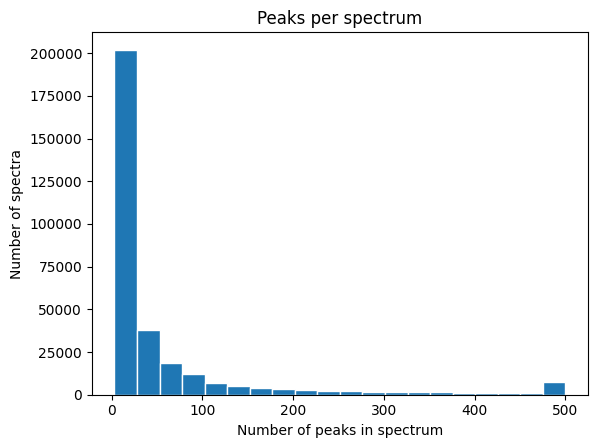

In [46]:
spec = DataExploration(spec_data)
spec.plot_peaks()

Examine the distribution of unique annotations vs total annotations; 

this gives us an idea of balance-imbalance structure of our data

Total Inchis: 314318 -- 24864 unique Inchis
Total Smiles: 314318 -- 32591 unique Smiles
Total Inchikeys: 314318 -- 20889 unique Inchikeys (first 14 characters)


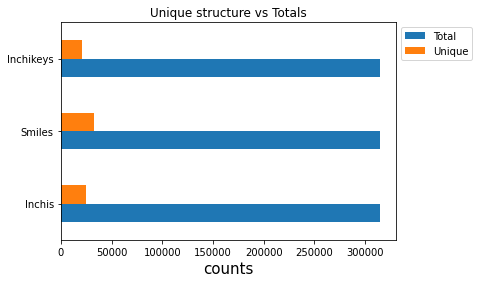

In [47]:
spec.count_annotations()

<b> Filter Unique inchiKey </b>

From the above step, we can see that the unique annotations (Inchis, IncheKeys, Smiles) are only a small fraction of the entire dataset. This means our data is imbalanced (some annotations are repeated more than the other).

We therefore need to find a way of improving the balance structure in this dataset. one way is to select only unique annotations. However this will leave us with only 20,889. This is huge drop (from 314,318 to 20,889). Alternatively we can trade off some imbalance for more data; by allowing an Inchikey to reoccour up to certain threshold.

To achieve this, we follow this tutorial by [louwenjjr
](https://github.com/louwenjjr/ms2_mass_differences/blob/ffd31aff66fba14502e3c7ec4f1b5eb947687ef1/scripts/mass_differences/processing.py) with some modifications to allow us to set reoccurance threshold.

In [48]:
# class DataFiltering:
#     def __init__(self, spectra):
#         self.spectra = spectra
        
#         # thresholds for selecting higher quality spectra
#         self.intensity_thres = 0.01
#         self.n_peaks_required = 10
#         self.gnps_spec_quality_measure = 3
    
#     def count_higher_peaks(self, index=0,threshold = 0.1):
#         spectrum = self.spectra[index]
#         return np.sum(spectrum.peaks.intensities/\
#                       spectrum.peaks.intensities.max() >= threshold)

    
#     def get_ids_for_unique_inchikeys(self): #: List[SpectrumType]
#         """Return indices for best chosen spectra for each unique inchikey
#         Parameters
#         ----------
#         spectrums:
#             Input spectra
#         """
#         # collect all inchikeys (first 14 characters)
#         inchikey_collection = OrderedDict()
#         for i, spec in enumerate(self.spectra):
#             inchikey = spec.get("inchikey")
#             if inchikey:
                
                    
#                 if inchikey[:14] in inchikey_collection:
#                     inchikey_collection[inchikey[:14]] += [i]
                   
                    
#                 else:
#                     inchikey_collection[inchikey[:14]] = [i]
            

        
#         ID_picks = []

#         inchikey14_unique = [x for x in inchikey_collection.keys()]

#         # Loop through all unique inchiques (14 first characters)
#         for inchikey14 in inchikey14_unique:
#             specIDs = np.array(inchikey_collection[inchikey14])
            
#             if specIDs.size == 1:
#                 ID_picks.append(specIDs[0])
#             else:
#                 # 1 select spec with sufficient peaks (e.g. 10 with intensity 0.01)
#                 num_peaks = np.array([self.count_higher_peaks(
#                     index=specID, threshold=self.intensity_thres) for
#                                       specID in specIDs])
#                 sufficient_peaks = np.where(num_peaks >= self.n_peaks_required)[0]
#                 if sufficient_peaks.size == 0:
#                     sufficient_peaks = np.where(num_peaks == max(num_peaks))[0]
#                 step1IDs = specIDs[sufficient_peaks]

#                 # 2 select best spectrum qualities
#                 # (according to gnps measure). 1 > 2 > 3
#                 qualities = np.array(
#                     [int(self.spectra[specID].get("library_class",\
#                                                   self.gnps_spec_quality_measure))
#                      for specID in step1IDs])  # default is 3; worst quality
#                 step2IDs = step1IDs[np.where(qualities == min(qualities))[0]]

#                 # 3 Select the ones with most peaks > threshold
#                 num_peaks = np.array([self.count_higher_peaks(
#                     index=specID, threshold=self.intensity_thres) for specID in step2IDs])
                
#                 pick = np.argmax(num_peaks)
#                 ID_picks.append(step2IDs[pick])
#         ID_picks.sort()  # ensure order

#         return ID_picks
    
#     # pick unique spectra using the unique inchikeys
    
#     def unique_spectra(self):
#         uniq_inchikeys = self.get_ids_for_unique_inchikeys()
#         uniq_spec_data = [self.spectra[i] for i in uniq_inchikeys]
        
#         return uniq_spec_data
        
    
   

In [51]:
class DataFiltering:
    def __init__(self, spectra):
        self.spectra = spectra
        
        # thresholds for selecting higher quality spectra
        self.intensity_thres = 0.01
        self.n_peaks_required = 10
        self.gnps_spec_quality_measure = 3
    
    def count_higher_peaks(self, index=0,threshold = 0.1):
        spectrum = self.spectra[index]
        return np.sum(spectrum.peaks.intensities/\
                      spectrum.peaks.intensities.max() >= threshold)

    
    def get_ids_for_unique_inchikeys(self,max_allowed=1): #: List[SpectrumType]
        """Return indices for best chosen spectra for each unique inchikey
        Parameters
        ----------
        spectrums:
            Input spectra
        """
        # collect all inchikeys (first 14 characters)
        inchikey_collection = OrderedDict()
        for i, spec in enumerate(self.spectra):
            inchikey = spec.get("inchikey")
            if inchikey:
                
                    
                if inchikey[:14] in inchikey_collection:
                    inchikey_collection[inchikey[:14]] += [i]
                   
                    
                else:
                    inchikey_collection[inchikey[:14]] = [i]
            

        
        ID_picks = []

        inchikey14_unique = [x for x in inchikey_collection.keys()]

        # Loop through all unique inchiques (14 first characters)
        for inchikey14 in inchikey14_unique:
            specIDs = np.array(inchikey_collection[inchikey14])
            
            if specIDs.size == 1:
                ID_picks.append(specIDs[0])
            else:
                # 1 select spec with sufficient peaks (e.g. 10 with intensity 0.01)
                num_peaks = np.array([self.count_higher_peaks(
                    index=specID, threshold=self.intensity_thres) for
                                      specID in specIDs])
                sufficient_peaks = np.where(num_peaks >= self.n_peaks_required)[0]
                
                
                
                if sufficient_peaks.size == 0:
                    sufficient_peaks = np.where(num_peaks == max(num_peaks))[0]
               
                step1IDs = specIDs[sufficient_peaks]
                
                
                #print('num_peak1', num_peaks)
                #print('step1id:',step1IDs)
                

                # 2 select best spectrum qualities
                # (according to gnps measure). 1 > 2 > 3
                qualities = np.array(
                    [int(self.spectra[specID].get("library_class",\
                                                  self.gnps_spec_quality_measure))
                     for specID in step1IDs])  # default is 3; worst quality
                #print('qualities',qualities)
                step2IDs = step1IDs[np.where(qualities == min(qualities))[0]]
                #print('step2id:',step2IDs)

                # 3 Select the ones with most peaks > threshold
                num_peaks = np.array([self.count_higher_peaks(
                    index=specID, threshold=self.intensity_thres) for specID in step2IDs])
                
                #pick = np.argmax(num_peaks)
                #ID_picks.append(step2IDs[pick])
                
                #Modified to return specified number of picks instead of the single best
                
                # order num_peaks and take the first specified instead of argmax
                num_peaks_sorted = np.sort(num_peaks)[::-1][:max_allowed]
                #print('num_peaks:',num_peaks)
                
                for i in num_peaks_sorted:
                    #pick = int(np.where(num_peaks == i)[0])
                    pick = list(num_peaks).index(i)
                    ID_picks.append(step2IDs[pick])
        
        ID_picks.sort()  # ensure order

        return ID_picks
    
    # pick unique spectra using the unique inchikeys
    
    def unique_spectra(self,max_allowed=1):
        uniq_inchikeys = self.get_ids_for_unique_inchikeys(max_allowed)
        uniq_spec_data = [self.spectra[i] for i in uniq_inchikeys]
        
        return uniq_spec_data
        
    
        

        


In [50]:
# call the filtering functions
unique_spectra = DataFiltering(spec_data).unique_spectra()

len(unique_spectra)

20889

In [52]:
# allow inchikey14 to reoccur max of 3
max3_spec = DataFiltering(spec_data).unique_spectra(max_allowed=3)
len(max3_spec)

41447

In [53]:
# # load df with all info
# path = './df_classes_all_embeddings.pickle'
# df_all = Files(path).load_pickle()#[:10000] #just a subset for scripting
# len(df_all)

<b> Explore the data after filtering </b>

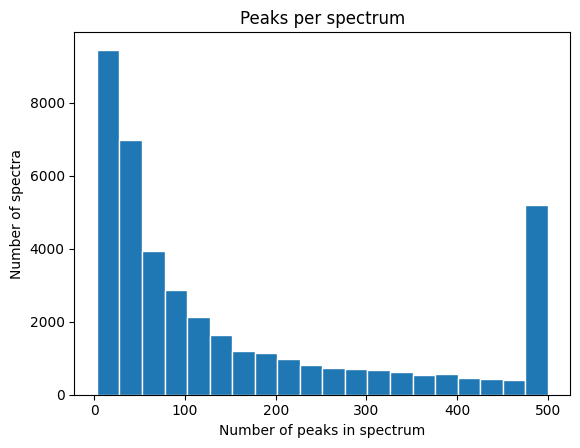

In [54]:
max3_expl = DataExploration(max3_spec)
max3_expl.plot_peaks()


Total Inchis: 41447 -- 21999 unique Inchis
Total Smiles: 41447 -- 23636 unique Smiles
Total Inchikeys: 41447 -- 20889 unique Inchikeys (first 14 characters)


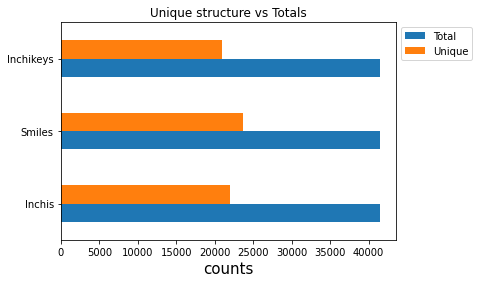

In [55]:
max3_expl.count_annotations()

# Part 2:  Generate embeddings


In this section, we generate embeddings from 3 pretrained models: 

(i) Spec2vec and (ii) MS2DeepScore  are for <b>spectra</b> embeddings while  (iii) Mol2vec is for <b>structure</b> emebbedings 

In [57]:
class Embeddings:
    def __init__(self, spectra, pretrained_model_path=None,\
                intensity_weighting_power = 0.5,\
                allowed_missing_percentage = 50):
        
        #model inputs
        self.spectra = spectra
        self.model = pretrained_model_path
        
        # pretrained model parameters
        self.intensity_weighting_power = intensity_weighting_power 
        self.allowed_missing_percentage =allowed_missing_percentage
        
    
    def spec2vec_documents(self, n_decimals=2):
        
        spec_documents = [SpectrumDocument(s, n_decimals=n_decimals)\
                              for s in self.spectra]
        return spec_documents
    
    def train_spec2vec(self,new_model_name,\
                      workers=2, iterations=25,\
                      progress_logger=False):
        spectrum_documents = self.spec2vec_documents()
        
        model = train_new_word2vec_model(spectrum_documents,iterations=[25],\
                                         filename=new_model_name,\
                                         workers=workers, \
                                         progress_logger=progress_logger)
        
        return None # saves the model.pickle to working dir
    
    def spec2vec_embeddings(self):
        # step 0: convert spectra to documents (uses the above function)
        model = gensim.models.Word2Vec.load(self.model)
        spectrum_documents = self.spec2vec_documents()
        
        #step 1: initialize an array of zeros
        spec2vec_embeddings = np.zeros((len(spectrum_documents),\
                                model.vector_size), dtype="float")
        
        # step 2: generate the embeddings
        for i, document in enumerate(tqdm(spectrum_documents)):
            spec2vec_embeddings[i, 0:model.vector_size] =\
            calc_vector(model, document,\
                        self.intensity_weighting_power,\
                        self.allowed_missing_percentage)
        
        return spec2vec_embeddings
    
    def spec2vec_similarity(self):
        
        spectrum_documents = self.spec2vec_documents()
        model = gensim.models.Word2Vec.load(self.model)
        
        # Define similarity_function
        spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)
        # Calculate scores on all combinations of reference spectrums and queries
        scores = calculate_scores(reference_documents, 
                                  query_spectrums, 
                                  spec2vec_similarity)

        
    
   
    
    # MS2Deepscore Embeddings
    
    def ms2deepscore_embeddings(self):
        
        #step 0: load the pretained model
        model = load_model(self.model)
        
        #step 1: init MS2DeepScore
        ms2deepscore_model_scores = MS2DeepScore(model)
        ms2deepscore_model_scores.model.spectrum_binner.allowed_missing_percentage = \
        self.allowed_missing_percentage
        
        #step 2: Generate embeddings from spectra
        ms2ds_embeddings = ms2deepscore_model_scores.calculate_vectors(self.spectra)
        return ms2ds_embeddings
    
    # Structure embeddings: Mol2vec
    
    def mol2vec_embeddings(self,smiles):
        
        #step 0: load the pretrained model
        model = word2vec.Word2Vec.load(self.model)
        
        # step 1: convert smiles to Molecules

        mols = pd.DataFrame([Chem.MolFromSmiles(smile) \
                             for smile in smiles], columns=['Mol'])
        
        # step 2: convert molecules to sentences
        sentence = pd.DataFrame(mols.apply(lambda x: \
                          MolSentence(mol2alt_sentence(x['Mol'], 1)), \
                          axis=1), columns=['mol2sent'])
        
        # step 3: generate mol2vec embeddings
        mol2vec_embeddings = [x for x in \
                 sentences2vec_updated(sentence['mol2sent'], \
                                       model, unseen='UNK')]
        
        # last; no need to store mols and sentences thus delete them 
        del mols, sentence
    
        return mol2vec_embeddings
    
    
    

    

### 2.1: Spec2vec embeddings fom a pretrained model

In [58]:
import gensim
from tqdm import tqdm

path_model ='../raw_data/spec2vec_model_GNPS_15_12_2021.model'


max3_spec2vec_embed = Embeddings(max3_spec,path_model).spec2vec_embeddings()

#write them to pickle file
filename = './max3_spec_embedding.pickle' # path
Files(filename).write_to_file(max3_spec2vec_embed)

100%|██████████████████████████████████████████████████████████████████████████| 41447/41447 [00:34<00:00, 1205.94it/s]


<b>Training A New Spec2Vec Model</b>



In [61]:
#Incase one has to train a new spec2vec model
from spec2vec.model_building import train_new_word2vec_model
new_model = './max3_spec2vec_model'
Embeddings(max3_spec).train_spec2vec(new_model)


### 2.2: MS2DeepScore embeddings fom a pretrained model


In [69]:
from ms2deepscore.models import load_model
from ms2deepscore import MS2DeepScore
model_path ='./ms2ds_model_GNPS_15_12_2021.hdf5'

# calls the functions defined in Embedding class
max3_ms2ds_embeddings = Embeddings(max3_spec,model_path).ms2deepscore_embeddings()

#write them to pickle file
filename = './max3_ms2ds_embedding.pickle' # path
Files(filename).write_to_file(max3_ms2ds_embeddings)

### 2.3: Mol2vec embeddings fom a pretrained model


Generating Mol2vec embeddings follows these [notebooks](https://github.com/samoturk/mol2vec/tree/master/examples) by Samoturk

In [62]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from gensim.models import word2vec

Pretrained model was downloaded from this [link](https://github.com/samoturk/mol2vec/blob/master/examples/models/model_300dim.pkl)

#### Update sentences2vec function

The function below had some errors *'AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0. Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.'*

So I took from the [source](https://github.com/samoturk/mol2vec/blob/master/mol2vec/features.py) then changed *'vocab.keys'* to *'key_to_index'*; *'word_vec'* to *'get_vector'*

Nothing else was changed from the original function

In [63]:
def sentences2vec_updated(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032
    Returns
    -------
    np.array
    """
    keys = set(model.wv.key_to_index.keys())
    vec = []
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)


In [67]:
# generate mol2vec unique emebeddings
smiles = [x.get('smiles') for x in max3_spec]
model = './model_300dim.pkl'

mol2vec_embeddings = Embeddings(max3_spec, model).mol2vec_embeddings(smiles)

#write them to pickle file
filename = './max3_mol2vec_embedding.pickle' # path
Files(filename).write_to_file(mol2vec_embeddings)

[15:50:33] WARNING: not removing hydrogen atom without neighbors


In [66]:
len(mol2vec_embeddings)

41447

In [46]:
#paths to embeddings
spec_max5 = './max5_spec_embedding.pickle'
ms2ds_max5 = './max5_ms2ds_embedding.pickle'
mol2vec_max5 = './max5_mol2vec_embedding.pickle'


spec2vec = Files(spec_max5).load_pickle()
ms2ds = Files(ms2ds_max5).load_pickle()
mol2vec = Files(mol2vec_max5).load_pickle()
    

#### <b> Moment of unified singularity :)</b>

Create single dataframe with all the data info: 

spectraID

annotations

Chemical class info

Embeddings

This will proceed to the next steps: <b>Model training</b>.


In [47]:
df = pd.DataFrame({'smiles': [spec.get('smiles') for spec in max5_spec],
                  'inchi_key': [spec.get('inchikey') for spec in max5_spec],
                   
                   # first 14 characters of inchikey
                   'inchikey14': [x[:14] for x in \
                                  [spec.get('inchikey') for spec in max5_spec]],
                   # add spectra Id
                   'spec_id':[f'spec_id{x}' for x in range(len(max5_spec))],
                       
                   #spectra embeddings
                   'spec2vec': [x for x in spec2vec],
                   'ms2ds': [x for x in ms2ds],
                   
                   # structure embeddings
                   'mol2vec':[x for x in mol2vec]
                  })
df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2..."
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,..."
2,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,spec_id2,"[-10.171258233684286, 7.6353667714294735, 4.62...","[0.0, 3.3309693336486816, 14.854373931884766, ...","[3.6706285, -0.5248031, -10.340071, 15.618862,..."
3,C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...,USXIYWCPCGVOKF-LERJCCFDSA-N,USXIYWCPCGVOKF,spec_id3,"[-2.172764877946671, 0.704987033808247, -2.564...","[0.0, 0.0, 14.163436889648438, 0.0, 0.0, 0.0, ...","[-0.17604338, -5.0714765, -6.3456626, 1.434744..."
4,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,spec_id4,"[-5.008793063971317, 32.11217206150628, -8.982...","[0.0, 0.0, 2.6736814975738525, 0.0, 0.0, 0.0, ...","[-0.3728091, -9.532841, -10.665195, 17.613012,..."


In [48]:
class_info_df.head()

,inchi_key,cf_class
0,IYDKWWDUBYWQGF-NNAZGLEUSA-N,Peptidomimetics
1,KNGPFNUOXXLKCN-ZNCJFREWSA-N,Peptidomimetics
2,WXDBUBIFYCCNLE-NSCMQRKRSA-N,Oxepanes
3,CGZKSPLDUIRCIO-RPCRKUJJSA-N,Indoles and derivatives
4,USXIYWCPCGVOKF-LERJCCFDSA-N,Peptidomimetics


In [49]:
#merge spec info with class info
df_merged = pd.merge(df, class_info_df, on=['inchi_key'], how='inner')

In [50]:
 df_merged.head()
        

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,spec_id2,"[-10.171258233684286, 7.6353667714294735, 4.62...","[0.0, 3.3309693336486816, 14.854373931884766, ...","[3.6706285, -0.5248031, -10.340071, 15.618862,...",Indoles and derivatives
3,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,spec_id234,"[-30.583942493730586, 2.31934233641017, -3.606...","[0.0, 0.0, 32.39744567871094, 0.0, 0.0, 0.0, 0...","[3.6706285, -0.5248031, -10.340071, 15.618862,...",Indoles and derivatives
4,C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...,USXIYWCPCGVOKF-LERJCCFDSA-N,USXIYWCPCGVOKF,spec_id3,"[-2.172764877946671, 0.704987033808247, -2.564...","[0.0, 0.0, 14.163436889648438, 0.0, 0.0, 0.0, ...","[-0.17604338, -5.0714765, -6.3456626, 1.434744...",Peptidomimetics


In [51]:
# write merged df to file
path = './df_classes_max5_embeddings.pickle'
Files(path).write_to_file(df_merged)

In [38]:
#paths to embeddings
spec_uniq = './spec2vec_embeddings_unique_GNPS_15_12_2021.pickle'
ms2ds_uniq = './ms2ds_embeddings_unique_GNPS_15_12_2021.pickle'
mol2vec_uniq = './unique_mol2vec_embedding.pickle'

#load the embeddings(ms2ds is upto 302514 so make them the same len)

spec2vec_uniq = Files(spec_uniq).load_pickle()
ms2ds_uniq = Files(ms2ds_uniq).load_pickle()
mol2vec_uniq = Files(mol2vec_uniq).load_pickle()
 

In [44]:
# for uniq spectra
#create a df with all info: point of singularity :)

df_uniq = pd.DataFrame({'smiles': [spec.get('smiles') for spec in unique_spectra],
                  'inchi_key': [spec.get('inchikey') for spec in unique_spectra],
                   
                   # first 14 characters of inchikey
                   'inchikey14': [x[:14] for x in \
                                  [spec.get('inchikey') for spec in unique_spectra]],
                   # add spectra Id
                   'spec_id':[f'spec_id{x}' for x in range(len(unique_spectra))],
                       
                   #spectra embeddings
                   'spec2vec': [x for x in spec2vec_uniq],
                   'ms2ds': [x for x in ms2ds_uniq],
                   
                   # structure embeddings
                   'mol2vec':[x for x in mol2vec_uniq]
                  })
df_uniq.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2..."
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,..."
2,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,spec_id2,"[-5.008793063971317, 32.11217206150628, -8.982...","[0.0, 0.0, 2.6736814975738525, 0.0, 0.0, 0.0, ...","[-0.3728091, -9.532841, -10.665195, 17.613012,..."
3,CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...,GWGKNTICBPKKKW-LBBUGJAGSA-N,GWGKNTICBPKKKW,spec_id3,"[16.967691713559265, 11.406365395323293, -5.16...","[0.0, 0.0, 8.311530113220215, 21.6807460784912...","[5.140757, -10.130683, -8.369965, 13.165277, -..."
4,CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...,FFCLYSVFZQXUHI-XUVLUQBSSA-N,FFCLYSVFZQXUHI,spec_id4,"[-32.38097167038966, -11.560462254295976, -4.1...","[0.0, 2.4228768348693848, 17.64068031311035, 0...","[-6.1560755, -6.321531, -5.7416663, -6.0778522..."


In [46]:
#merge spec info with class info: unified singularity :)
df_uniq_merged = pd.merge(df_uniq, class_info_df, on=['inchi_key'], how='inner')
df_uniq_merged.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,spec_id2,"[-5.008793063971317, 32.11217206150628, -8.982...","[0.0, 0.0, 2.6736814975738525, 0.0, 0.0, 0.0, ...","[-0.3728091, -9.532841, -10.665195, 17.613012,...",Macrolactams
3,CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...,GWGKNTICBPKKKW-LBBUGJAGSA-N,GWGKNTICBPKKKW,spec_id3,"[16.967691713559265, 11.406365395323293, -5.16...","[0.0, 0.0, 8.311530113220215, 21.6807460784912...","[5.140757, -10.130683, -8.369965, 13.165277, -...",Peptidomimetics
4,CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...,FFCLYSVFZQXUHI-XUVLUQBSSA-N,FFCLYSVFZQXUHI,spec_id4,"[-32.38097167038966, -11.560462254295976, -4.1...","[0.0, 2.4228768348693848, 17.64068031311035, 0...","[-6.1560755, -6.321531, -5.7416663, -6.0778522...",Carboxylic acids and derivatives


In [47]:
# write merged df to file
path = './df_classes_unique_embeddings.pickle'
Files(path).write_to_file(df_uniq_merged)

In [10]:
path= './df_classes_all_embeddings.pickle'
df = Files(path).load_pickle()
df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,CCMSLIB00000001547,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901464462280273, 37.367000579833984, ...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,CCMSLIB00000001548,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.6031694412231445, 12.245128631591797, ...","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000001549,"[-6.807433213493404, 2.8870356459664226, -4.28...","[28.570608139038086, 7.199506759643555, 10.875...","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
3,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000071752,"[-3.703751099226352, -2.2908253516762493, 6.72...","[17.48873519897461, 0.0, 29.71199607849121, 0....","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
4,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,CCMSLIB00000001550,"[-10.171258233684286, 7.6353667714294735, 4.62...","[0.0, 3.3309712409973145, 14.854373931884766, ...","[3.6706285, -0.5248031, -10.340071, 15.618862,...",Indoles and derivatives


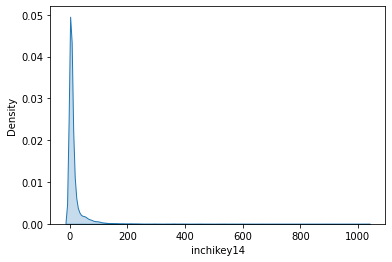

In [11]:
#Are the inchikyes equally repeated?
ax=sn.kdeplot(df['inchikey14'].value_counts(), shade=True)
    

plt.show()

In [12]:
#check which classes are highly represented
df_class_counts = df['cf_class'].value_counts().\
rename_axis('cf_class').reset_index(name='counts')

df_class_counts.head()

,cf_class,counts
0,Prenol lipids,41477
1,Flavonoids,35174
2,Benzene and substituted derivatives,18978
3,Steroids and steroid derivatives,18661
4,Carboxylic acids and derivatives,17156


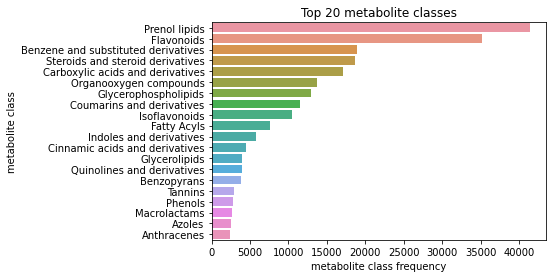

In [22]:

sns.barpl

## Visualizing Embeddings

Just a rough visualization of the embeddings for now (don't worry too much about it :)

In [1]:
import tqdm
import umap
from sklearn.manifold import TSNE
import os
import pandas as pd
import numpy as np
import umap.plot
from matplotlib import pyplot as plt
import seaborn as sns



In [48]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle',
 'unique_mol2vec_embedding.pickle']

In [8]:
uniq_ms2ds = './ms2ds_embeddings_unique_GNPS_15_12_2021.pickle'
uniq_spec2vec = './spec2vec_embeddings_unique_GNPS_15_12_2021.pickle'

uniq_ms2ds = Files(uniq_ms2ds).load_pickle()
uniq_spec2vec = Files(uniq_spec2vec).load_pickle()

In [28]:
tsne = TSNE(n_components=2,  random_state=0, learning_rate='auto').fit_transform(uniq_ms2ds)

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


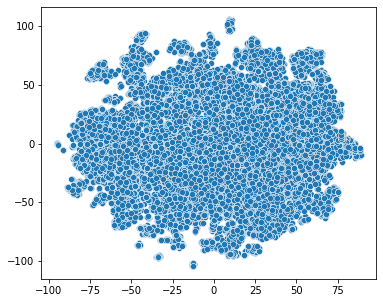

In [29]:
#warning  comes cause it expects a df
plt.figure(figsize=(6,5))
sns.scatterplot(tsne[:,0], tsne[:,1])
plt.show()